In [1]:
import numpy as np
import cv2, imutils, re
import matplotlib.pyplot as plt
from collections import Counter


In [2]:
def get_image(image_path, iter=2, width=None):
    image = cv2.imread(image_path)
    image = cv2.copyMakeBorder(
        image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=(255, 255, 255)
    )
    if width:
        image = imutils.resize(image, width)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 75, 200)

    paper = image.copy()

    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # kernel = np.ones((3, 3), np.uint8)
    # thresh = cv2.erode(thresh, kernel, iterations=iter)
    # thresh = cv2.dilate(thresh, kernel, iterations=iter)
    thresh = cv2.erode(thresh, None, iterations=iter)
    thresh = cv2.dilate(thresh, None, iterations=iter)

    ctrs = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ctrs = imutils.grab_contours(ctrs)

    return image, ctrs, paper, gray, edged, thresh


In [3]:
def sort_contours(image, ctrs, diam):
    BB = [list(cv2.boundingRect(c)) for c in ctrs]
    tol = 0.7 * diam

    def sort(i):
        S = sorted(BB, key=lambda x: x[i])
        s = [b[i] for b in S]
        m = s[0]

        for b in S:
            if m - tol < b[i] < m or m < b[i] < m + tol:
                b[i] = m
            elif b[i] > m + diam:
                for e in s[s.index(m) :]:
                    if e > m + diam:
                        m = e
                        break
        return sorted(set(s))

    xs = sort(0)
    ys = sort(1)

    (ctrs, BB) = zip(
        *sorted(zip(ctrs, BB), key=lambda b: b[1][1] * len(image) + b[1][0])
    )
    return ctrs, BB, xs, ys


def get_circles(ctrs, diam):
    questionCtrs = []
    for c in ctrs:
        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / float(h)

        if diam * 0.8 <= w <= diam * 1.2 and 0.8 <= ar <= 1.2:
            questionCtrs.append(c)
    return questionCtrs


def get_diameter(ctrs):
    boundingBoxes = [list(cv2.boundingRect(c)) for c in ctrs]
    c = Counter([i[2] for i in boundingBoxes])
    mode = c.most_common(1)[0][0]
    if mode > 1:
        diam = mode
    else:
        diam = c.most_common(2)[1][0]
    return diam


def draw_contours(paper, boundingBoxes, questionCtrs):
    color = (0, 255, 0)
    i = 0
    for q in range(len(questionCtrs)):
        cv2.drawContours(paper, questionCtrs[q], -1, color, 3)
        cv2.putText(
            paper,
            str(i),
            (
                boundingBoxes[q][0] + boundingBoxes[q][2] // 2,
                boundingBoxes[q][1] + boundingBoxes[q][3] // 2,
            ),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            2,
        )
        i += 1
    return paper


In [4]:
def get_spacing(boundingBoxes, diam, xs):

    def spacing(x):
        space = []
        coor = [b[x] for b in boundingBoxes]
        for i in range(len(coor) - 1):
            c = coor[i + 1] - coor[i]
            if c > diam // 2:
                space.append(c)
        return sorted(list(set(space)))

    spacingX = spacing(0)
    spacingY = spacing(1)

    # m = min(spacingX)
    # c = 0
    d1 = spacingX[0]
    d2 = 0
    d3 = 0

    for x in spacingX:
        if d2 == 0 and x > d1 * 1.3:
            d2 = x
        if d2 > 0 and x > d2 * 1.3:
            d3 = x
            break

    linesV = []
    prev = 0  # outside

    linesV.append(min(xs) - (d2 - diam) / 2)

    for i in range(1, len(xs)):
        diff = xs[i] - xs[i - 1]
        if i == 1 and d2 * 0.9 < diff:
            linesV.append(min(xs) - d2 - diam / 2)
            prev = 1
        if d1 * 0.8 < diff < d1 * 1.2:
            linesV.append(xs[i - 1] + diam + (d1 - diam) / 2)
            prev = 1
        elif d2 * 0.8 < diff < d2 * 1.1:
            linesV.append(xs[i - 1] + diam + (d2 - diam) / 2)
            prev = 0
        elif d3 * 0.9 < diff < d3 * 1.1:
            if prev == 1:
                linesV.append(xs[i - 1] + diam + (d2 - diam) / 2)
                linesV.append(xs[i - 1] + d2 + diam + (d1 - diam) / 2)
            else:
                linesV.append(xs[i - 1] + diam + (d1 - diam) / 2)
                linesV.append(xs[i - 1] + d1 + diam + (d2 - diam) / 2)
        elif d3 * 1.1 < diff:
            if prev == 1:
                linesV.append(xs[i - 1] + diam + (d2 - diam) / 2)
                linesV.append(xs[i - 1] + d2 + diam + (d1 - diam) / 2)
                linesV.append(xs[i - 1] + d3 + diam + (d2 - diam) / 2)
                prev = 0
            else:
                linesV.append(xs[i - 1] + diam + (d1 - diam) / 2)
                linesV.append(xs[i - 1] + d1 + diam + (d2 - diam) / 2)
                linesV.append(xs[i - 1] + d1 + d2 + diam + (d1 - diam) / 2)
                linesV.append(xs[i - 1] + d1 + d3 + diam + (d2 - diam) / 2)
                prev = 1

    linesV.append(max(xs) + diam * 1.5)
    if len(linesV) % 2 == 0:
        linesV.append(max(xs) + d2 + diam)

    return linesV, d1, d2, d3, spacingX, spacingY


def display_contours(paper, linesV, figsize=(15, 30), lines=False):

    plt.figure(figsize=figsize)
    plt.rcParams["axes.grid"] = False
    plt.rcParams["axes.spines.left"] = False
    plt.axis("off")
    plt.imshow(paper)
    if lines:
        for x in linesV:
            plt.axvline(x)

    plt.show()


In [5]:
def get_letters(boundingBoxes, diam, spacingY, linesV, showID=False):

    Bxs = list(boundingBoxes)
    Bxs.append((100000, 0))

    dots = [[]]
    for y in sorted(list(set(spacingY))):
        if y > 1.3 * diam:
            minYD = y * 1.5
            break

    for b in range(len(Bxs) - 1):
        if Bxs[b][0] < Bxs[b + 1][0]:
            if showID:
                dots[-1].append((b, Bxs[b][0:2]))
            else:
                dots[-1].append(Bxs[b][0])
        else:
            if abs(Bxs[b + 1][1] - Bxs[b][1]) < minYD:
                if showID:
                    dots[-1].append((b, Bxs[b][0:2]))
                else:
                    dots[-1].append(Bxs[b][0])
                dots.append([])
            else:
                if showID:
                    dots[-1].append((b, Bxs[b][0:2]))
                else:
                    dots[-1].append(Bxs[b][0])
                dots.append([])
                if len(dots) % 3 == 0 and not dots[-1]:
                    dots.append([])

    letters = []

    for r in range(len(dots)):
        if not dots[r]:
            letters.append([0 for _ in range(len(linesV) - 1)])
            continue
        else:
            letters.append([])
            c = 0
            i = 0
            while i < len(linesV) - 1:
                if c < len(dots[r]):
                    if linesV[i] < dots[r][c] < linesV[i + 1]:
                        letters[-1].append(1)
                        c += 1
                    else:
                        letters[-1].append(0)
                else:
                    letters[-1].append(0)
                i += 1

    # for l in range(len(letters)):
    #     if l % 3 == 0:
    #         print()
    #     print(letters[l])
    # print()

    return letters


In [6]:
def translate(letters):

    alpha = {
        "a": "1",
        "b": "13",
        "c": "12",
        "d": "124",
        "e": "14",
        "f": "123",
        "g": "1234",
        "h": "134",
        "i": "23",
        "j": "234",
        "k": "15",
        "l": "135",
        "m": "125",
        "n": "1245",
        "o": "145",
        "p": "1235",
        "q": "12345",
        "r": "1345",
        "s": "235",
        "t": "2345",
        "u": "156",
        "v": "1356",
        "w": "2346",
        "x": "1256",
        "y": "12456",
        "z": "1456",
        "#": "2456",
        "^": "6",
        ",": "3",
        ".": "346",
        '"': "356",
        "^": "26",
        ":": "34",
        "'": "5",
    }

    nums = {
        "a": "1",
        "b": "2",
        "c": "3",
        "d": "4",
        "e": "5",
        "f": "6",
        "g": "7",
        "h": "8",
        "i": "9",
        "j": "0",
    }

    braille = {v: k for k, v in alpha.items()}

    letters = np.array([np.array(l) for l in letters])

    ans = ""

    for r in range(0, len(letters), 3):
        for c in range(0, len(letters[0]), 2):
            f = letters[r : r + 3, c : c + 2].flatten()
            f = "".join([str(i + 1) for i, d in enumerate(f) if d == 1])
            if f == "6":
                f = "26"
            if not f:
                if ans[-1] != " ":
                    ans += " "
            elif f in braille.keys():
                ans += braille[f]
            else:
                ans += "?"
        if ans[-1] != " ":
            ans += " "

    # replace numbers
    def replace_nums(m):
        return nums.get(m.group("key"), m.group(0))

    ans = re.sub("#(?P<key>[a-zA-Z])", replace_nums, ans)

    # capitalize
    def capitalize(m):
        return m.group(0).upper()[1]

    ans = re.sub("\^(?P<key>[a-zA-Z])", capitalize, ans)

    return ans


In [7]:
# image_path = './data/4ggIni9.jpeg' # iter=0 not work
# image_path = './data/4nC067a.jpeg' # iter=2
image_path = "./data/EjBz4nI.jpeg"  # iter=0
# image_path = './data/ihU7tFt.jpeg' # iter=2
# image_path = './data/maU4r0t.jpeg' # iter=2
# image_path = './data/nFT74Mv.jpeg' # iter=2
# image_path = './data/NwLqmz2.jpeg' # iter=3
# image_path = './data/osNCAx3.jpeg' # iter=2
# image_path = './data/ttq5PzE.jpeg' # iter=2
# image_path = './data/UBqs60s.jpeg' # iter=2
image, ctrs, paper, gray, edged, thresh = get_image(image_path, iter=2, width=1500)


diam = get_diameter(ctrs)
dotCtrs = get_circles(ctrs, diam)

questionCtrs, boundingBoxes, xs, ys = sort_contours(image, ctrs, diam)
paper = draw_contours(paper, boundingBoxes, questionCtrs)

linesV, d1, d2, d3, spacingX, spacingY = get_spacing(boundingBoxes, diam, xs)

letters = get_letters(boundingBoxes, diam, spacingY, linesV)
ans = translate(letters)


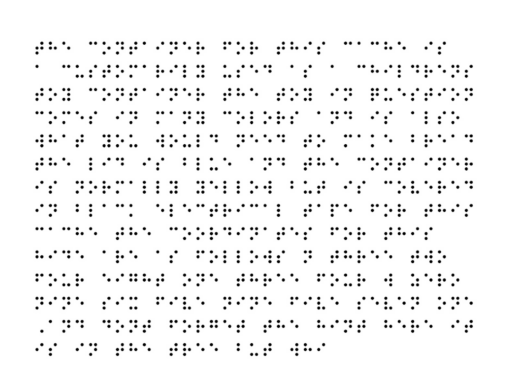

the container for this cache is a customarily used as a childrens toy container the toy in question comes in many colors and is also what you would need to make bread the lid is blue and the container is normally yellow but is covered in black electrical tape for this cache the coordinates for this hide are as follows n three two four eight one three four w zero nine six five nine five seven one And dont forget the hint here it is in the tree but whi 


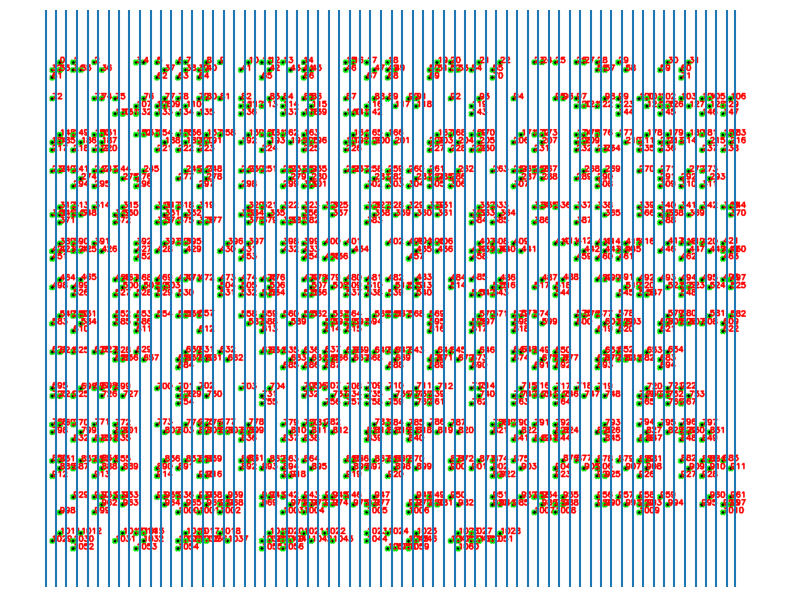

In [8]:
plt.axis("off")
plt.imshow(image)
plt.show()

print(ans)

display_contours(paper, linesV, (10, 20), True)


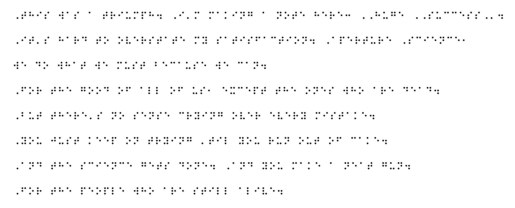

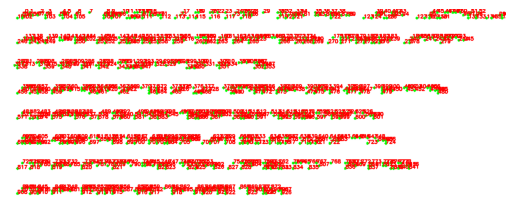

In [41]:
import cv2
import numpy as np
import imutils
import re
from collections import Counter
import matplotlib.pyplot as plt

# 이미지 전처리 함수
def preprocess_image(image_path, width=None, iterations=2):
    """
    이미지를 로드하고 전처리 작업을 수행합니다.
    """
    try:
        image = cv2.imread(image_path)
        image = cv2.copyMakeBorder(image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=(255, 255, 255))
        if width:
            image = imutils.resize(image, width)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edged = cv2.Canny(blurred, 75, 200)

        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        kernel = np.ones((5, 5), np.uint8)
        thresh = cv2.erode(thresh, kernel, iterations=iterations)
        thresh = cv2.dilate(thresh, kernel, iterations=iterations)

        contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)

        return image, contours, gray, edged, thresh
    except Exception as e:
        print(f"Error occurred during image preprocessing: {e}")
        return None, None, None, None, None

# 점자 점 추출 함수
def extract_braille_dots(contours, image):
    """
    이미지에서 점자 점을 추출합니다.
    """
    try:
        bounding_boxes = [cv2.boundingRect(c) for c in contours]
        diameter = get_most_common_diameter(bounding_boxes)

        braille_dots = []
        for contour in contours:
            (x, y, w, h) = cv2.boundingRect(contour)
            aspect_ratio = w / float(h)

            if diameter * 0.8 <= w <= diameter * 1.2 and 0.8 <= aspect_ratio <= 1.2:
                braille_dots.append(contour)

        return braille_dots, diameter
    except Exception as e:
        print(f"Error occurred during braille dot extraction: {e}")
        return [], 0

# 점자 점 정렬 함수
def sort_braille_dots(contours, diameter, image):
    """
    점자 점을 정렬하고 바운딩 박스를 계산합니다.
    """
    try:
        bounding_boxes = [list(cv2.boundingRect(c)) for c in contours]
        tolerance = 0.7 * diameter

        def sort_coordinates(index):
            """
            주어진 인덱스(x 또는 y)에 대한 좌표를 정렬합니다.
            """
            sorted_coords = sorted({b[index] for b in bounding_boxes})
            groups = []
            current_group = [sorted_coords[0]]

            for coord in sorted_coords[1:]:
                if abs(coord - current_group[-1]) > tolerance:
                    groups.append(current_group)
                    current_group = [coord]
                else:
                    current_group.append(coord)

            if current_group:
                groups.append(current_group)

            return groups

        x_groups = sort_coordinates(0)
        y_groups = sort_coordinates(1)

        # 점자 점 및 바운딩 박스 정렬
        sorted_contours = []
        sorted_bounding_boxes = []
        for y_group in y_groups:
            for x_group in x_groups:
                for y in y_group:
                    for x in x_group:
                        for i, (c, b) in enumerate(zip(contours, bounding_boxes)):
                            if b[0] == x and b[1] == y:
                                sorted_contours.append(c)
                                sorted_bounding_boxes.append(b)
                                bounding_boxes[i] = None
                                break

        return sorted_contours, sorted_bounding_boxes
    except Exception as e:
        print(f"Error occurred during braille dot sorting: {e}")
        return [], []

# 가장 많이 등장하는 직경 계산 함수
def get_most_common_diameter(bounding_boxes):
    """
    바운딩 박스에서 가장 많이 등장하는 직경을 계산합니다.
    """
    diameters = [b[2] for b in bounding_boxes]
    counter = Counter(diameters)
    most_common = counter.most_common(2)

    if len(most_common) >= 2:
        return most_common[1][0]
    else:
        return most_common[0][0]

# 점자 점 그리기 함수
def draw_braille_dots(image, sorted_contours, sorted_bounding_boxes):
    """
    이미지에 점자 점과 번호를 그립니다.
    """
    paper = image.copy()
    color = (0, 255, 0)
    i = 0

    for contour, bounding_box in zip(sorted_contours, sorted_bounding_boxes):
        cv2.drawContours(paper, [contour], -1, color, 3)
        cv2.putText(
            paper,
            str(i),
            (bounding_box[0] + bounding_box[2] // 2, bounding_box[1] + bounding_box[3] // 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            2,
        )
        i += 1

    return paper

# 점자 패턴 인식 함수
def recognize_braille_pattern(sorted_bounding_boxes, diameter, spacing_x, spacing_y):
    """
    점자 패턴을 인식하고 문자로 변환합니다.
    """
    try:
        # 가로 및 세로 간격 계산
        def calculate_spacing(index):
            spacing = []
            coords = [b[index] for b in sorted_bounding_boxes]
            for i in range(len(coords) - 1):
                distance = coords[i + 1] - coords[i]
                if distance > diameter // 2:
                    spacing.append(distance)
            return sorted(set(spacing))

        spacing_x = calculate_spacing(0)
        spacing_y = calculate_spacing(1)

        # 세로줄 위치 계산
        vertical_lines = []
        prev_x = 0
        vertical_lines.append(min(spacing_x) - (spacing_x[1] - diameter) / 2)

        for i in range(1, len(spacing_x)):
            diff = spacing_x[i] - spacing_x[i - 1]
            if diff >= spacing_x[1] * 0.9:
                if prev_x == 0:
                    vertical_lines.append(min(spacing_x) - spacing_x[1] - diameter / 2)
                    prev_x = 1


In [117]:
test = [
    8,
    # 16,
    25,
    84,
    92,
    100,
    159,
    168,
    176,
    235,
    244,
    252,
    311,
    320,
    328,
    387,
    395,
    # 403,
    # 463,
    471,
    479,
    539,
    # 547,
    555,
]


In [118]:
len(test)


20

In [119]:
num = 0
num_list = [0]
for i in range(len(test)):
    if i != len(test) - 1:
        if num % 3 == 2 or test[i + 1] - test[i] > 10:
            num_list.append(i + 1)
            num = 0
        else:
            num += 1
    elif test[i] - test[i - 1] > 10:
        num_list.append(i + 1)
    else:
        num_list.pop()
        num_list.append(i + 1)
num_list


[0, 1, 2, 5, 8, 11, 14, 16, 18, 19, 20]

In [120]:
for i in range(len(num_list) - 1):
    print(test[num_list[i] : num_list[i + 1]])


[8]
[25]
[84, 92, 100]
[159, 168, 176]
[235, 244, 252]
[311, 320, 328]
[387, 395]
[471, 479]
[539]
[555]


In [70]:
print(test[0:2])
print(test[2:5])
print(test[5:8])
print(test[8:11])
print(test[22])


[8, 16]
[84, 92, 100]
[159, 168, 176]
[235, 244, 252]
555
